In [1]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

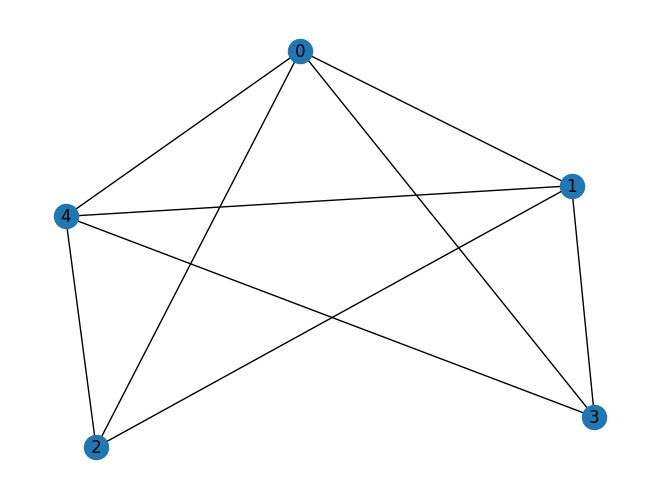

In [2]:
def detRandomGraph(n):
    #Genereate tree as base for final graph
    G = nx.random_tree(n, seed=42)
    
    #Number of edges in addition graph
    k = math.sqrt(n)/2
    
    #Fill in tree with new edges
    G.add_edges_from(nx.gnm_random_graph(n, n-1+k, seed=42).edges())

    #Display the graph
    nx.draw(G, with_labels=True)
    plt.show()
    
    return G

detRandomGraph(5)

In [3]:
#Create the individual and fitness types using DEAP creator and create toolbox
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [4]:
#Create toolbox
def createToolbox():
    toolbox = base.Toolbox()
    return toolbox

In [5]:
#Register necessary tools for creating individuals and population to toolbox
def registerIndPop(toolbox, num_nodes):
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, num_nodes)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [6]:
#Define fitness function
def evalMIS(individual):
    return sum(individual),

#Register evaluation function to toolbox
def registerFitness(toolbox):
    toolbox.register("evaluate", evalMIS)

In [7]:
#Register genetic operators to toolbox
def registerGeneticOperators(toolbox):
    toolbox.register("mate", tools.cxTwoPoint) #crossover
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.10) #mutation
    toolbox.register("select", tools.selTournament, tournsize=3) #selection

In [8]:
#Create function to check if an individual represents an independent set
def is_ind_set(G, individual):
    #Get indexs of 1's from individual
    nodes = []
    i = 0
    for bit in individual:        
        if bit==1:
            nodes.append(i)
        i += 1
#     print(nodes)
    
    #Check if node set is independent
    for u in nodes:
        for v in nodes:
            if u != v and G.has_edge(u,v):
                return False, nodes
    return True, nodes   

In [9]:
#Create function to "repair" non-feasible solutions
def repairIndividual(G, individual):
    result, nodes = is_ind_set(G, individual)
    #print(nodes)
    if result==True:
        return
    else:
        max_deg = -1
        node_to_remove = -1
        for node in nodes:
            if G.degree[node] > max_deg:
                max_deg = G.degree[node]
                node_to_remove = node
        individual[node_to_remove] = 0
        repairIndividual(G, individual)
        
#Register repair function to the toolbox
def registerRepair(toolbox):
    toolbox.register("repair", repairIndividual)

In [10]:
#Define genetic algorithm
def eaSimpleWithRepair(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        
        #-------Inserted Repair Step-----------
        for ind in offspring:
            toolbox.repair(G, ind)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [11]:
#Define the genetic algorithm
def GA(toolbox, G):
    import numpy
    
    pop = toolbox.population(n=50)
    for ind in pop:
            toolbox.repair(G, ind)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = eaSimpleWithRepair(pop, toolbox, 
                                      cxpb=0.5, mutpb=0.2, ngen=10,
                                      stats=stats, halloffame=hof, verbose=False)
    
    return pop, logbook, hof

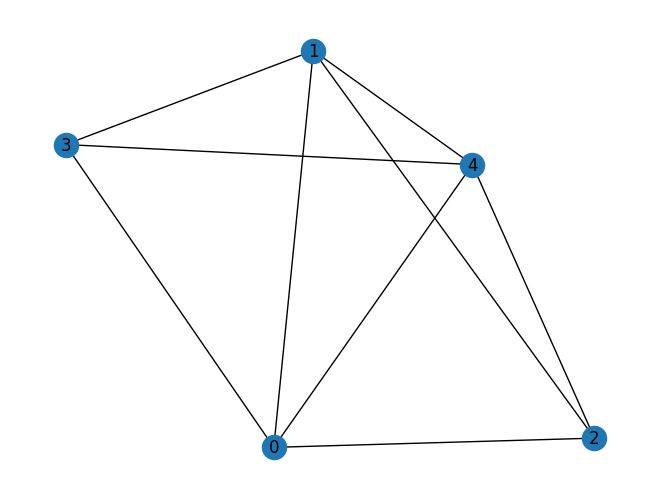

====== Results for graph of size 5 ======
[[0, 0, 1, 1, 0], [0, 0, 1, 1, 0]]
gen	nevals	avg 	min	max
0  	50    	1.12	0  	2  
1  	28    	1.38	1  	2  
2  	27    	1.64	0  	2  
3  	29    	1.9 	1  	2  
4  	28    	1.98	1  	2  
5  	36    	1.96	1  	2  
6  	24    	1.96	1  	2  
7  	37    	2   	2  	2  
8  	22    	1.94	0  	2  
9  	34    	1.9 	1  	2  
10 	24    	1.98	1  	2  
Best individual is: [0, 0, 1, 1, 0]
with fitness: (2.0,)
======== print out statistic info ========


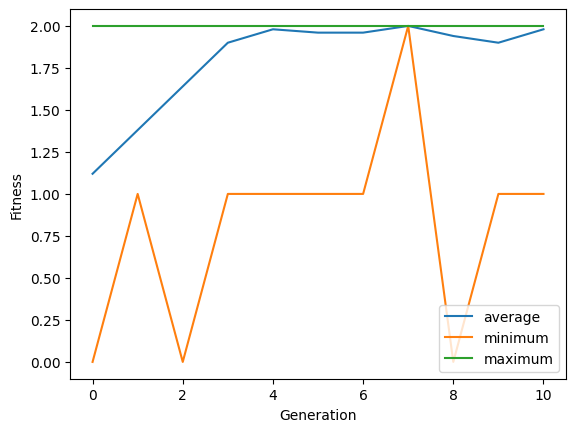

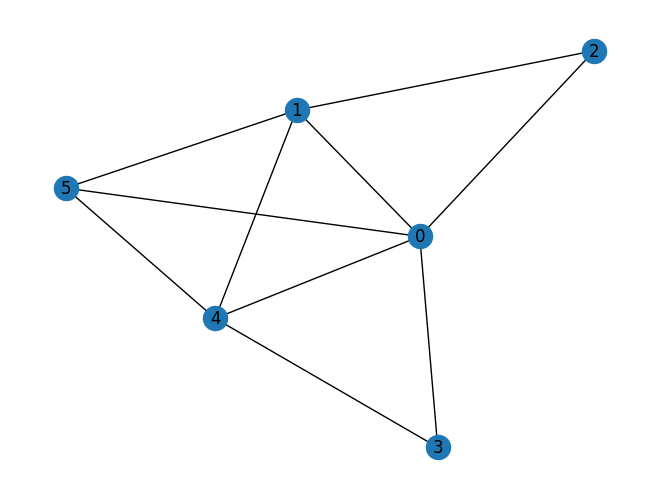

====== Results for graph of size 6 ======
[[0, 0, 1, 1, 0, 1], [0, 0, 1, 1, 0, 1]]
gen	nevals	avg 	min	max
0  	50    	1.6 	1  	3  
1  	27    	2.08	1  	3  
2  	28    	2.52	1  	3  
3  	33    	2.9 	2  	3  
4  	28    	3   	3  	3  
5  	29    	2.96	2  	3  
6  	33    	2.94	2  	3  
7  	35    	2.98	2  	3  
8  	31    	2.94	2  	3  
9  	27    	2.9 	2  	3  
10 	29    	2.94	1  	3  
Best individual is: [0, 0, 1, 1, 0, 1]
with fitness: (3.0,)
======== print out statistic info ========


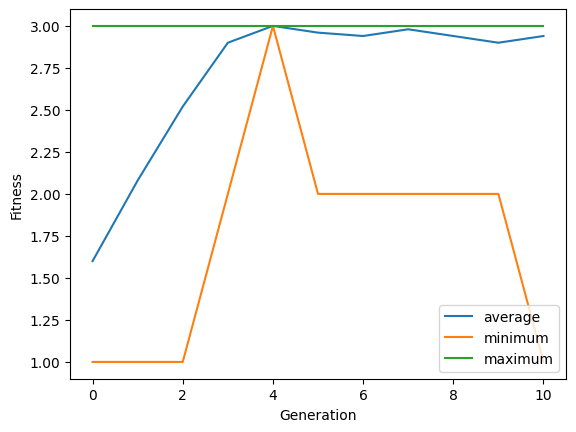

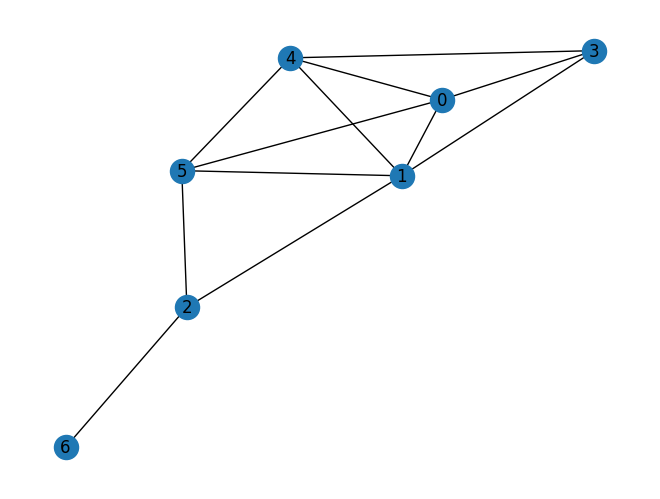

====== Results for graph of size 7 ======
[[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 1]]
gen	nevals	avg 	min	max
0  	50    	1.64	0  	3  
1  	27    	2.24	0  	3  
2  	30    	2.72	1  	3  
3  	32    	2.92	2  	3  
4  	34    	2.98	2  	3  
5  	35    	2.96	2  	3  
6  	24    	2.94	2  	3  
7  	34    	2.96	2  	3  
8  	37    	2.92	2  	3  
9  	31    	2.96	2  	3  
10 	32    	2.9 	1  	3  
Best individual is: [0, 0, 0, 1, 0, 1, 1]
with fitness: (3.0,)
======== print out statistic info ========


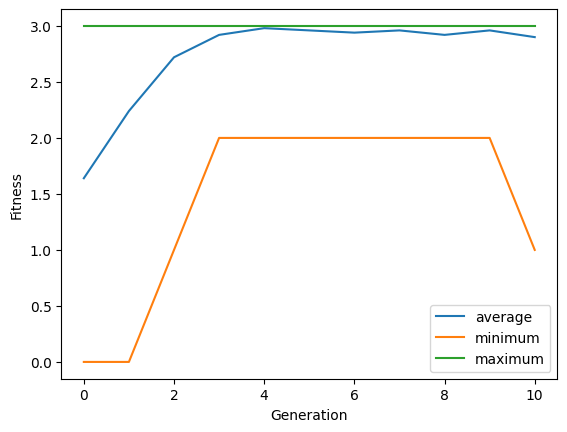

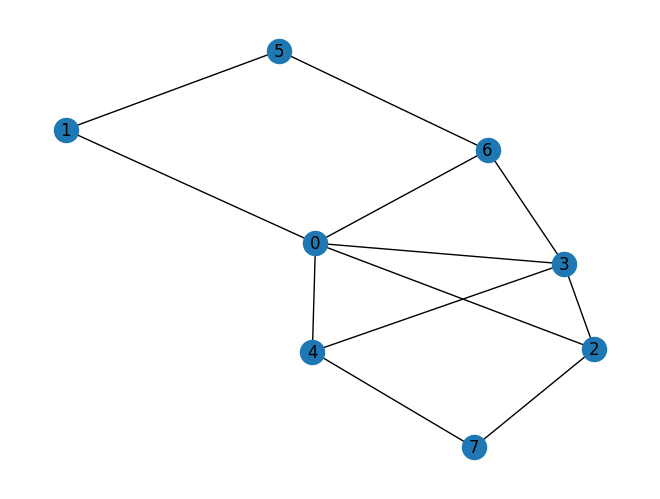

====== Results for graph of size 8 ======
[[0, 1, 1, 0, 1, 0, 1, 0], [0, 1, 1, 0, 1, 0, 1, 0]]
gen	nevals	avg 	min	max
0  	50    	1.78	1  	4  
1  	31    	2.12	1  	3  
2  	36    	2.46	1  	3  
3  	31    	2.76	1  	4  
4  	32    	2.8 	1  	4  
5  	37    	3.16	2  	4  
6  	28    	3.38	1  	4  
7  	30    	3.82	3  	4  
8  	27    	3.86	1  	4  
9  	30    	3.92	3  	4  
10 	27    	3.92	1  	4  
Best individual is: [0, 1, 1, 0, 1, 0, 1, 0]
with fitness: (4.0,)
======== print out statistic info ========


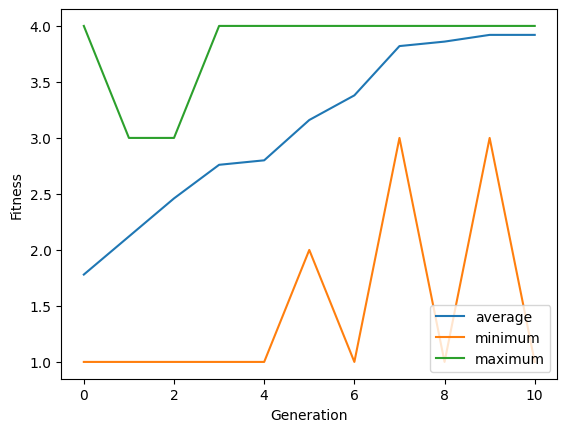

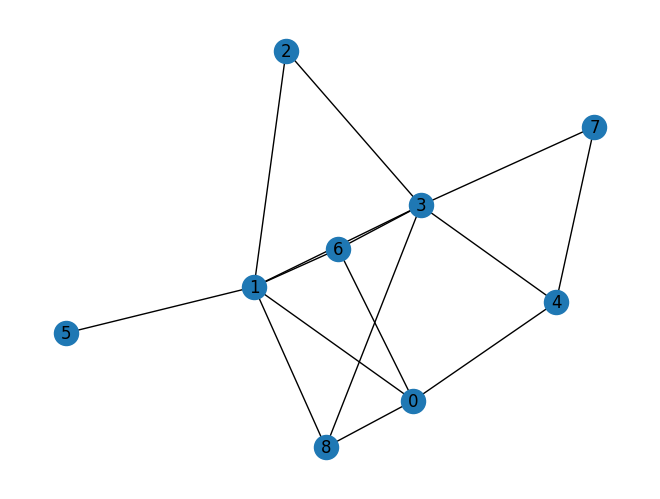

====== Results for graph of size 9 ======
[[0, 0, 1, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 1]]
gen	nevals	avg 	min	max
0  	50    	2.62	1  	4  
1  	33    	3.22	2  	5  
2  	34    	3.58	2  	5  
3  	30    	4   	2  	5  
4  	25    	4.44	3  	5  
5  	31    	4.8 	4  	5  
6  	36    	4.84	4  	5  
7  	29    	4.92	3  	5  
8  	38    	4.98	4  	5  
9  	33    	4.88	3  	5  
10 	36    	4.92	3  	5  
Best individual is: [0, 0, 1, 0, 0, 1, 1, 1, 1]
with fitness: (5.0,)
======== print out statistic info ========


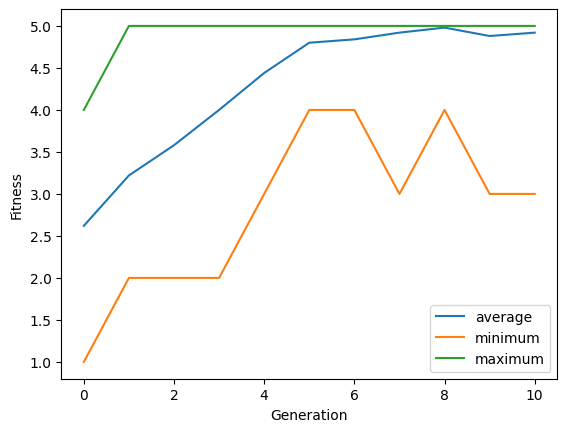

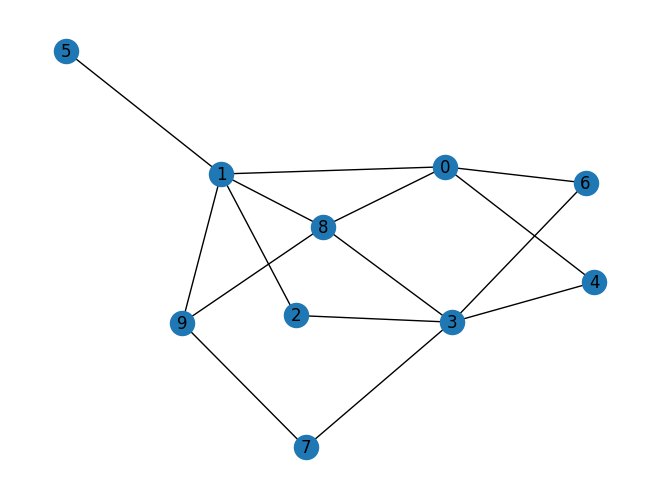

====== Results for graph of size 10 ======
[[0, 0, 1, 0, 1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 1, 1, 1, 1, 1, 0]]
gen	nevals	avg 	min	max
0  	50    	3.08	1  	5  
1  	34    	3.78	2  	5  
2  	31    	4.34	2  	6  
3  	38    	4.78	3  	6  
4  	38    	4.92	4  	6  
5  	35    	5   	3  	6  
6  	24    	5.24	3  	6  
7  	32    	5.54	4  	6  
8  	27    	5.92	5  	6  
9  	28    	5.84	4  	6  
10 	23    	5.9 	4  	6  
Best individual is: [0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
with fitness: (6.0,)
======== print out statistic info ========


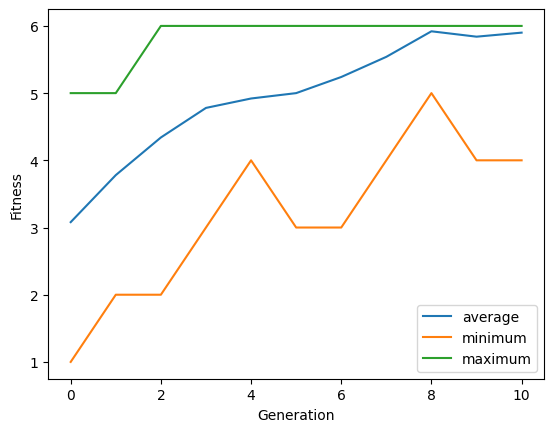

In [12]:
if __name__ == "__main__":
    
    for n in range(5, 11):
        #Generate underlying deterministic random graph
        G = detRandomGraph(n)
        
        #Create toolbox and register all methods
        toolbox = createToolbox()
        registerIndPop(toolbox, n)
        registerFitness(toolbox)
        registerGeneticOperators(toolbox)
        registerRepair(toolbox)
    
        #Run algorithm on graph G
        pop, log, hof = GA(toolbox, G)

        #Display the results
        print("====== Results for graph of size %s ======" % (n))
        print(pop[:2]) #print the first two individuals in the final population
        print(log)
        print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
        #nevals: the number of evaluations in the last generation

        print("======== print out statistic info ========")
        import matplotlib.pyplot as plt
        gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
        plt.plot(gen, avg, label="average")
        plt.plot(gen, min_, label="minimum")
        plt.plot(gen, max_, label="maximum")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend(loc="lower right")
        plt.show()